In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

### Week 3: Histopathologic Cancer Detection

#### Problem:
This project involves analyzing medical images and building a good CNN model to identify images showing symptoms of metastatic cancer. The data is sourced from https://www.kaggle.com/c/histopathologic-cancer-detection/overview, which itself is a slightly modified version of the PatchCamelyon dataset (supposedly with duplicates removed). The dataset is fairly large, with about 220,000 images in the training data (and another 57.5k for the test set). The training data comes with labels (for whether there is metastatic cancer).

#### EDA:
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Starting with importing the training labels into a dataframe. Label data is pretty straightforward, 220,025 entries, with an id as well as the actual label (0 for no cancer, 1 for with cancer).

In [2]:
label_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv', dtype=str)

print(label_df.info())
print(label_df.columns)
label_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None
Index(['id', 'label'], dtype='object')


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Checking for null values or duplicate rows. The Kaggle mentions duplicates were removed, but want to make sure. Doesn't seem like there's any missing or duplicated values though, so not much to clean.

In [3]:
# Check for null
na_count = label_df.isna().sum()
print("Null count:", na_count)

# Check for dupes
dupes = label_df['id'].duplicated()
print("Duplicate rows: ", dupes.sum())

Null count: id       0
label    0
dtype: int64
Duplicate rows:  0


I want to check the distribution of images labeled 0 and 1 to see if it's imbalanced. Overall, there's more 0s than 1s, but it's not overly imbalanced.

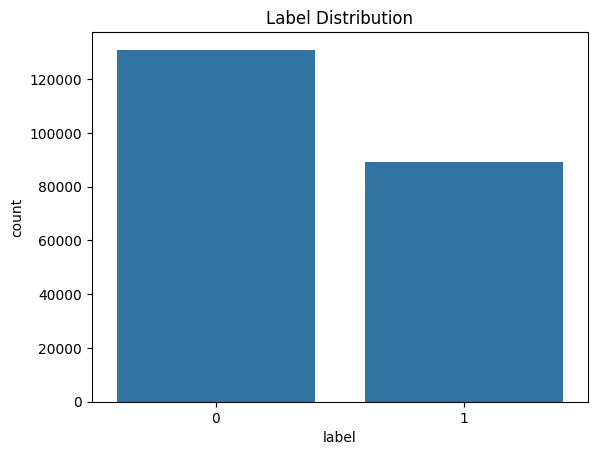

In [4]:
# Draw 0/1 label plot
sns.countplot(x='label', data=label_df)
plt.title('Label Distribution')
plt.show()

Showing some example images for reference. Also taking a look at image sizes, all images seem to be 96x96, which is good to know so I know what size input I'll need for the models.

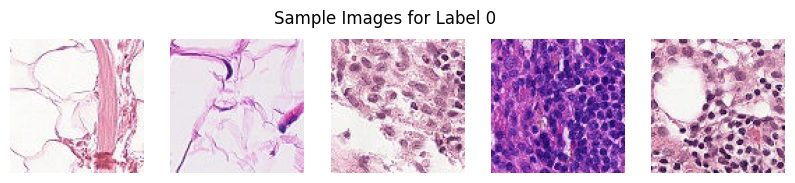

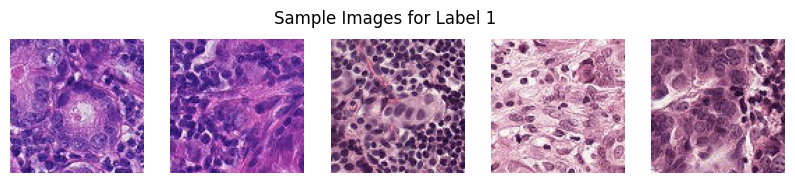

Image Sizes:  [(96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96), (96, 96)]


In [5]:
train_image_path = ('histopathologic-cancer-detection/train/')
test_image_path = ('histopathologic-cancer-detection/test/')

sizes = []

def sample_images(label, num_samples=3):
    sample_images = label_df[label_df['label'] == str(label)].sample(num_samples)
    plt.figure(figsize=(10, 2))
    
    for i, img_name in enumerate(sample_images['id']):
        img_path = os.path.join(train_image_path, img_name + '.tif')
        img = Image.open(img_path)
        sizes.append(img.size)
        plt.subplot(1, num_samples, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
        
    plt.suptitle(f'Sample Images for Label {label}') 
    plt.show()


sample_images(0, 5)  
sample_images(1, 5)
print("Image Sizes: ", sizes)

I also want to split the training set into train/validation sets before I start training the model. I'll try to split the 0s and 1s evenly so the training data is balanced. I'm also only going to use 1/5 of the images, at least during testing, just so my models can run faster.

In [6]:
from sklearn.model_selection import train_test_split
# Splitting data

#Might want to make this smaller for testing purposes?
zeros = label_df[label_df['label'] == '0']#.sample(frac=0.2, random_state=10)
ones = label_df[label_df['label'] == '1']#.sample(frac=0.2, random_state=10)

train0, val0 = train_test_split(zeros, test_size=0.3, random_state=10)
train1, val1 = train_test_split(ones, test_size=0.3, random_state=10)

train_set = pd.concat([train0, train1])
train_set['id'] = train_image_path + train_set['id'] + '.tif'
val_set = pd.concat([val0, val1])
val_set['id'] = train_image_path + val_set['id'] + '.tif'

print(train_set['label'].value_counts())

label
0    91635
1    62381
Name: count, dtype: int64


Creating the data generators for the training and validation data. Rescaling to normalize pixel values to [0,1] range.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (96, 96)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_set,
    x_col = "id",
    y_col = "label",
    target_size = IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=val_set,
    x_col = "id",
    y_col = "label",
    target_size=IMG_SIZE,
    color_mode = "rgb",
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 123213 non-validated image filenames belonging to 2 classes.
Found 13201 non-validated image filenames belonging to 2 classes.


#### Model Architecture:
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

For the first model, I'm keeping things simple using a Sequential Model, with 2 Convolution layers and MaxPooling in between, and ending with a Sigmoid activation function (since we want the output to be 0 or 1).

In [8]:
# Basic Model:
def basic_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = basic_CNN()
basic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,200,961 (50.36 MB)

 Trainable params: 13,200,961 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

I'll also use a second model with a 3rd Convolution layer and a Dropout Layer for regularization, which should hopefully improve the accuracy and help avoid potential overfitting.

In [24]:
# Model with extra Convolution layer + Regularization
def dropout_CNN():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

dropout_model = dropout_CNN()
dropout_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Starting with compiling and training on the basic model (2 Conv layers, no regularization). I'll use the Adam optimizer and binary-cross entropy for the loss function. I've set the learning rate at 0.001, which I'm hoping is some sort of middle ground.

In [10]:
# First compilation with basic

LEARN_RATE = 0.001
EPOCHS = 30
SPE = 300 # lowering steps per epoch to speed things up

optimizer = tf.keras.optimizers.Adam(LEARN_RATE)

basic_model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [11]:
history1 = basic_model.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.6334 - loss: 0.7598 - val_accuracy: 0.7600 - val_loss: 0.5378
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.7674 - loss: 0.4900 - val_accuracy: 0.7263 - val_loss: 0.5974
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - accuracy: 0.7716 - loss: 0.4800 - val_accuracy: 0.7356 - val_loss: 0.4965
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7788 - loss: 0.4675 - val_accuracy: 0.7409 - val_loss: 0.5566
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.7946 - loss: 0.4548 - val_accuracy: 0.7543 - val_loss: 0.5010
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.7879 - loss: 0.4498 - val_accuracy: 0.8481 - val_loss: 0.3239
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.7930 - loss: 0.4545 - val_accuracy: 0.7749 - val_loss: 0.4847
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.8044 - loss: 0.4362 - val

2024-11-26 18:37:17.569014: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.8280 - loss: 0.3859 - val_accuracy: 0.9042 - val_loss: 0.2790
Epoch 14/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8213 - loss: 0.3951 - val_accuracy: 0.8554 - val_loss: 0.3386
Epoch 15/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8348 - loss: 0.3789 - val_accuracy: 0.8531 - val_loss: 0.3514
Epoch 16/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8335 - loss: 0.3662 - val_accuracy: 0.7999 - val_loss: 0.4579
Epoch 17/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.8413 - loss: 0.3624 - val_accuracy: 0.8037 - val_loss: 0.4631
Epoch 18/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.8425 - loss: 0.3565 - val_accuracy: 0.8395 - val_loss: 0.3716
Epoch 19/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.8475 - loss: 0.3598 - val_accuracy: 0.8077 - val_loss: 0.4357
Epoch 20/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.8562 - loss: 0.3395

2024-11-26 18:44:24.937293: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.8687 - loss: 0.3141 - val_accuracy: 0.7409 - val_loss: 0.5391
Epoch 27/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.8811 - loss: 0.2846 - val_accuracy: 0.8833 - val_loss: 0.2778
Epoch 28/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.8804 - loss: 0.2867 - val_accuracy: 0.7806 - val_loss: 0.4769
Epoch 29/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.8901 - loss: 0.2767 - val_accuracy: 0.8497 - val_loss: 0.3402
Epoch 30/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.8851 - loss: 0.2772 - val_accuracy: 0.9024 - val_loss: 0.2275


Next, I'll try the same parameters (Adam optimizer, binary cross-entropy loss function, .001 learn rate), and fit the model with a 3rd convolution layer and a dropout layer for regularization.

In [12]:
# Second compilation with the improved model

optimizer2 = tf.keras.optimizers.Adam(LEARN_RATE)

dropout_model.compile(loss='binary_crossentropy',
             optimizer=optimizer2,
             metrics=['accuracy'])

In [13]:
history2 = dropout_model.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.6766 - loss: 0.5999 - val_accuracy: 0.7987 - val_loss: 0.4588
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.7777 - loss: 0.4831 - val_accuracy: 0.8512 - val_loss: 0.3928
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.7611 - loss: 0.5025 - val_accuracy: 0.8490 - val_loss: 0.3633
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.7863 - loss: 0.4714 - val_accuracy: 0.7405 - val_loss: 0.5755
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.7977 - loss: 0.4484 - val_accuracy: 0.8567 - val_loss: 0.3667
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.7943 - loss: 0.4543 - val_accuracy: 0.7696 - val_loss: 0.5072
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.7978 - loss: 0.4459 - val_accuracy: 0.8625 - val_loss: 0.3440
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.8092 - loss: 0.4355 - 

2024-11-26 19:19:07.922176: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.8778 - loss: 0.3008 - val_accuracy: 0.8494 - val_loss: 0.3237
Epoch 27/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.8745 - loss: 0.2936 - val_accuracy: 0.8220 - val_loss: 0.3852
Epoch 28/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.8761 - loss: 0.2917 - val_accuracy: 0.8703 - val_loss: 0.2671
Epoch 29/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.8770 - loss: 0.3020 - val_accuracy: 0.9550 - val_loss: 0.1377
Epoch 30/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.8706 - loss: 0.3179 - val_accuracy: 0.8521 - val_loss: 0.3204


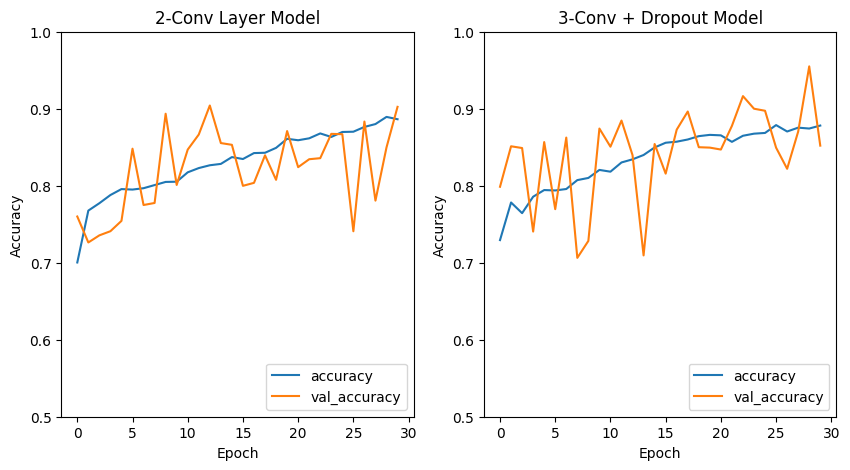

In [37]:
# Graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history1.history['accuracy'], label='accuracy')
ax1.plot(history1.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.5, 1])
ax1.set_title('2-Conv Layer Model')
ax1.legend(loc='lower right')

ax2.plot(history2.history['accuracy'], label='accuracy')
ax2.plot(history2.history['val_accuracy'], label = 'val_accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.5, 1])
ax2.set_title('3-Conv + Dropout Model')
ax2.legend(loc='lower right')



Overall, comparing the 2 runs, the performance seems quite similar. The first model has slightly lower peaks with the validation accuracy, but it's not too far off from the second model, so at least for this dataset, maybe the regularization and extra convolution layer isn't contributing too much.

The biggest issue seems to be the validation accuracy just jumping around. This is most likely because the learning rate is too high, and it's stepping over the global minimum instead of getting closer to it. To fix this, I'll try adjusting how the weight is handled by adding a weight decay to the Adam optimizer. The Keras Adam optimizer supposedly has some momentum built in already, but it might need some help still.

In [26]:
optimizer3 = tf.keras.optimizers.Adam(LEARN_RATE, weight_decay=1e-5)

dropout_model3 = dropout_CNN()

dropout_model3.compile(loss='binary_crossentropy',
             optimizer=optimizer3,
             metrics=['accuracy'])

history3 = dropout_model3.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.6061 - loss: 0.6556 - val_accuracy: 0.8862 - val_loss: 0.3563
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.7622 - loss: 0.5048 - val_accuracy: 0.7405 - val_loss: 0.5221
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.7727 - loss: 0.4900 - val_accuracy: 0.7595 - val_loss: 0.5258
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.7792 - loss: 0.4804 - val_accuracy: 0.7649 - val_loss: 0.4951
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.7925 - loss: 0.4555 - val_accuracy: 0.8221 - val_loss: 0.4296
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.7722 - loss: 0.4810 - val_accuracy: 0.8409 - val_loss: 0.3828
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.7879 - loss: 0.4594 - val_accuracy: 0.7592 - val_loss: 0.5095
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.8059 - loss: 0.4299 - 

In [28]:
optimizer4 = tf.keras.optimizers.Adam(0.0001)

dropout_model4 = dropout_CNN()
# dropout_model3.summary()

dropout_model4.compile(loss='binary_crossentropy',
             optimizer=optimizer4,
             metrics=['accuracy'])

history4 = dropout_model4.fit(train_generator, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                steps_per_epoch = SPE,
                validation_data=validation_generator)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.6441 - loss: 0.6270 - val_accuracy: 0.7636 - val_loss: 0.5024
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.7733 - loss: 0.4879 - val_accuracy: 0.7058 - val_loss: 0.5810
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.7707 - loss: 0.4992 - val_accuracy: 0.8154 - val_loss: 0.4143
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.7768 - loss: 0.4924 - val_accuracy: 0.6406 - val_loss: 0.7398
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.7787 - loss: 0.4743 - val_accuracy: 0.8613 - val_loss: 0.3513
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.7743 - loss: 0.4839 - val_accuracy: 0.8170 - val_loss: 0.4302
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.7779 - loss: 0.4716 - val_accuracy: 0.8090 - val_loss: 0.4450
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.7856 - loss: 0.4569 - 

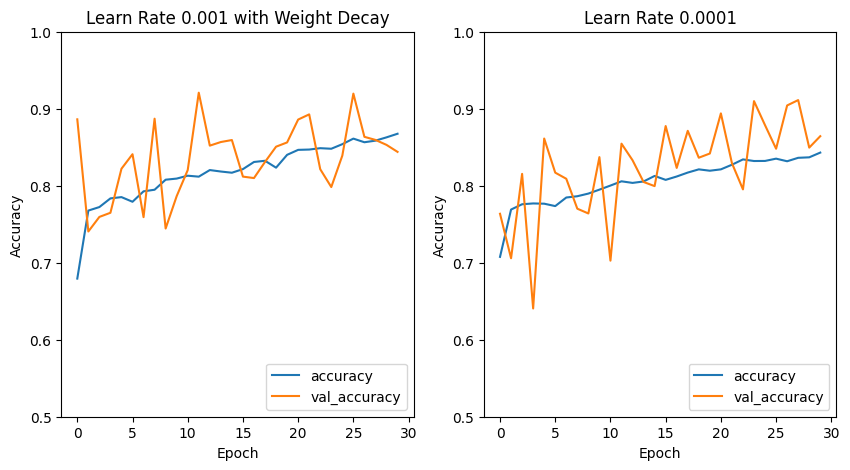

In [38]:
# Graphs
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5))

ax3.plot(history3.history['accuracy'], label='accuracy')
ax3.plot(history3.history['val_accuracy'], label = 'val_accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_ylim([0.5, 1])
ax3.set_title('Learn Rate 0.001 with Weight Decay')
ax3.legend(loc='lower right')

ax4.plot(history4.history['accuracy'], label='accuracy')
ax4.plot(history4.history['val_accuracy'], label = 'val_accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.set_ylim([0.5, 1])
ax4.set_title('Learn Rate 0.0001')
ax4.legend(loc='lower right')

#### Conclusion
Overall, while I had difficulty improving over the basic model I'd created (with 2 convolution layers and a 0.001 learn rate with Adam), lowering the Learning Rate did lead to a more stable increase in validation accuracy. I opted to stick wtih the 0.0001 learning rate.

As far as possible further improvements, it's possible that picking Adam as my optimizer was a mistake, and that I should've gone for the more basic SGD optimizer, to have further control over the learning rates. With the higher learning rate, the accuracy was too inconsistent to draw any real conclusions, and with the lower learning rate, there's the risk that it's only finding a local minimum instead of the global minimum. Ideally, I want some balance between the 2, which I was hoping would be solved with weight decay on Adam, but it's possible the issue was with the choice in optimizer itself.

#placeholder